## CarND Advanced Lane Finding

CRITERIA:

1. Camera Calibration
2. Distortion correction that was calculated via camera calibration
3. A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image
4. OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view".
5. Methods have been used to identify lane line pixels in the rectified binary image. 
6. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.
7. The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries.
8. The image processing pipeline that was established to find the lane lines in images successfully processes the video.


### Camera Calibration

### Distortion Correction

### Color/gradient Threshold

### Perspective Transform

### Detect Lane Lines

### Determine the Lane Curvature

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import cv2
import glob
import collections
from itertools import chain
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Color/gradient Threshold

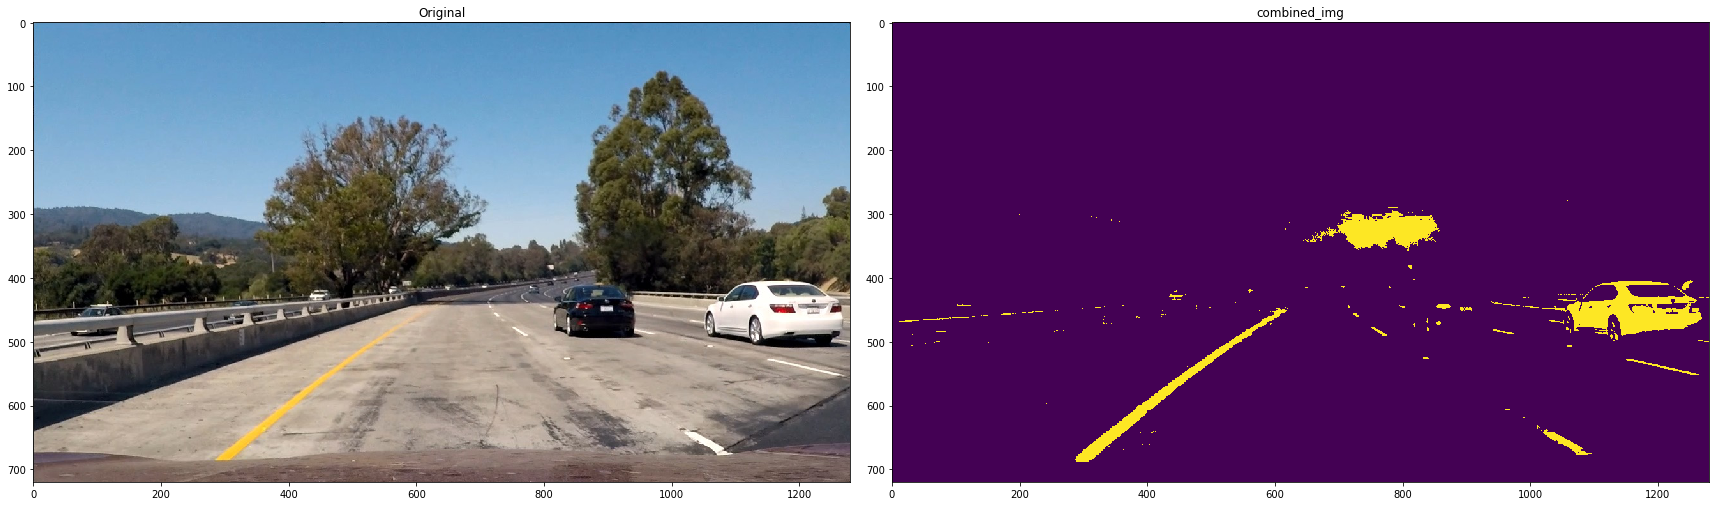

In [63]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def hls_threshold(img, channel='s', thresh = (0,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 's':
        ch = hls[:,:,2]
    elif channel == 'l':
        ch = hls[:,:,1]
    elif channel == 'h':
        ch = hls[:,:,0]
    else:
        raise Exception('channel input error!')
    binary_output = np.zeros_like(ch)
    binary_output[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    
    return binary_output

def hsv_threshold(img, channel='s', thresh = (0,255)):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if channel == 'v':
        ch = hsv[:,:,2]
    elif channel == 's':
        ch = hsv[:,:,1]
    elif channel == 'h':
        ch = hsv[:,:,0]
    else:
        raise Exception('channel input error!')
    binary_output = np.zeros_like(ch)
    binary_output[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    
    return binary_output

def lab_threshold(img, channel='l', thresh = (0,255)):
    
    image_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if channel == 'b':
        ch = image_lab[:,:,2]
    elif channel == 'a':
        ch = image_lab[:,:,1]
    elif channel == 'l':
        ch = image_lab[:,:,0]
    else:
        raise Exception('channel input error!')
    lab_binary = np.zeros_like(ch)
    lab_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    
    return lab_binary


def rgb_threshold(img, channel='r', thresh = (0,255)):
    
    image_rgb = np.copy(img)
    if channel == 'b':
        ch = image_rgb[:,:,2]
    elif channel == 'g':
        ch = image_rgb[:,:,1]
    elif channel == 'r':
        ch = image_rgb[:,:,0]
    else:
        raise Exception('channel input error!')
    rgb_binary = np.zeros_like(ch)
    rgb_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    
    return rgb_binary


def yuv_threshold(img, channel='y', thresh = (0,255)):
    
    image_yuv =  cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if channel == 'v':
        ch = image_yuv[:,:,2]
    elif channel == 'u':
        ch = image_yuv[:,:,1]
    elif channel == 'y':
        ch = image_yuv[:,:,0]
    else:
        raise Exception('channel input error!')
    yuv_binary = np.zeros_like(ch)
    yuv_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    
    return yuv_binary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def combined_filter(image):
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(112, 1000))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(112, 1000))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(29, 1000))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=np.array([40, 89])*np.pi/180.0)
    s_binary = hls_threshold(image, channel='s', thresh = (188,255))
    l_binary = hls_threshold(image, channel='l', thresh = (202,255))
    s_hsv_binary = hsv_threshold(image, channel='s', thresh = (83,255))
    l_lab_binary = lab_threshold(image, channel='l', thresh = (177,255))
    a_lab_binary = lab_threshold(image, channel='a', thresh = (20,255))
    b_lab_binary = lab_threshold(image, channel='b', thresh = (129,255))  #120155
    r_rgb_binary = rgb_threshold(image, channel='r', thresh = (220,255))
    g_rgb_binary = rgb_threshold(image, channel='g', thresh = (171,255))
    u_yuv_binary = yuv_threshold(image, channel='u', thresh = (145,255))
    edges = canny(image, 200, 400)
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1)  & (l_binary == 1)] = 1
    
    combined = np.zeros_like(s_binary)
    
    combined[(r_rgb_binary == 1) | (sl_binary == 1) |  (l_binary == 1) | (u_yuv_binary == 1) ] = 1    
    
    if False:
        f, ax = plt.subplots(4, 2, figsize=(24, 9))
        f.tight_layout()
        ax[0][0].imshow(r_rgb_binary, cmap='gray')
        ax[0][0].set_title('R binary')
        ax[0][1].imshow(s_binary, cmap='gray')
        ax[0][1].set_title('S channel')
        ax[1][0].imshow(l_binary, cmap='gray')
        ax[1][0].set_title('L channel')
        ax[1][1].imshow(sl_binary, cmap='gray')
        ax[1][1].set_title('SL channel')
        ax[2][0].imshow(u_yuv_binary, cmap='gray')
        ax[2][0].set_title('U channel')
        ax[2][1].imshow(edges)
        ax[2][1].set_title('canny channel')
        ax[3][0].imshow(combined)
        ax[3][0].set_title('Combined Image')
        ax[3][1].imshow(image)
        ax[3][1].set_title('Original Image')
        plt.show()    
    return combined

fname = 'test_images/test1.jpg'
img1 = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
combined_img = combined_filter(img1)

if True:
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(24, 9))
    f.tight_layout()
    ax[0].imshow(img1)
    ax[0].set_title('Original')

    ax[1].imshow(combined_filter(img1))
    ax[1].set_title('combined_img')
    plt.show()    

### Distortion Correction

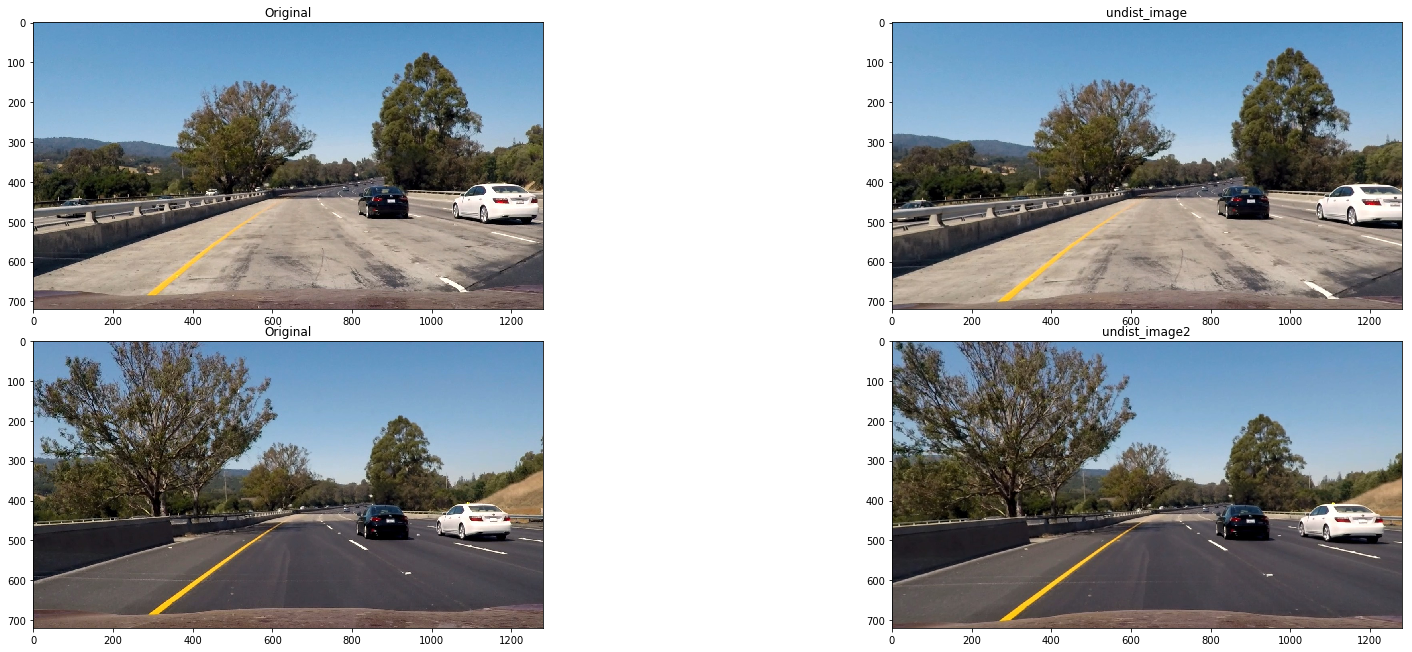

In [3]:
def undist_image(image):
    
    dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

fname = 'test_images/test1.jpg'
test_image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

fname2 = 'test_images/test6.jpg'
test_image2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)

if True:
    f, ax = plt.subplots(2, 2, figsize=(24, 9))
    f.tight_layout()
    ax[0][0].imshow(test_image)
    ax[0][0].set_title('Original')

    ax[0][1].imshow(undist_image(test_image))
    ax[0][1].set_title('undist_image')
    
    ax[1][0].imshow(test_image2)
    ax[1][0].set_title('Original')

    ax[1][1].imshow(undist_image(test_image2))
    ax[1][1].set_title('undist_image2')
    
    plt.show()

### Perspective Transform

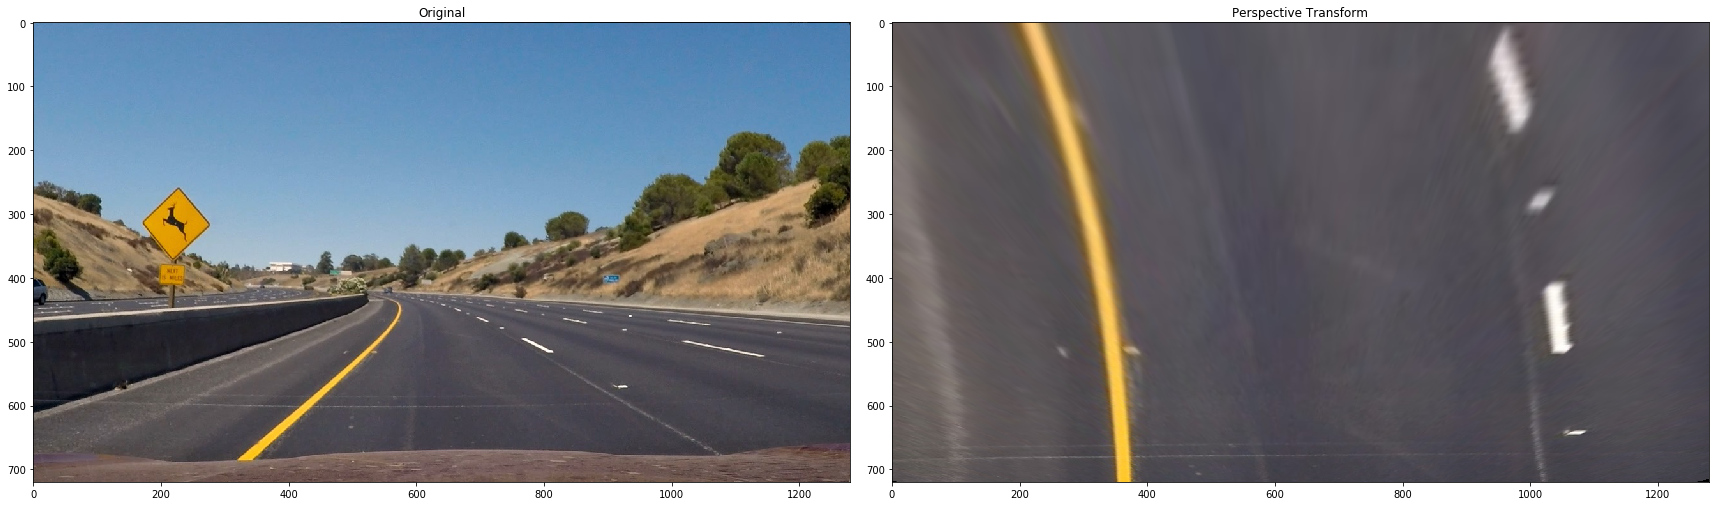

In [58]:
src_corners = np.array([[585, 460], [698, 460], [995, 659], [296, 659]], np.float32) #2 686
dst_corners = np.array([[300, 0], [1280 - 300, 0], [1280 - 300, 720], [300, 720]], np.float32)
M = cv2.getPerspectiveTransform(src_corners, dst_corners)
M_inv = cv2.getPerspectiveTransform(dst_corners, src_corners)

def transform(img):
     return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
def inv_transform(img):
     return cv2.warpPerspective(img, M_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    


    
fname = "test_images/test2.jpg"
orig_img = plt.imread(fname)
undist_img = undist_image(orig_img)

#plt.figure(figsize=(10,10))
#plt.imshow(orig_img)
#plt.plot([555,680,1180,300,555],[400,400,680,680,400],color='RED', linewidth=4)

f, ax = plt.subplots(ncols=2,nrows=1, figsize=(24, 9))
f.tight_layout()
ax[0].imshow(orig_img)
ax[0].set_title('Original')

ax[1].imshow(transform(undist_img))
ax[1].set_title('Perspective Transform')
    

### Detect Lane Lines

### Determine the Lane Curvature

In [10]:
def find_lines(img, create_example_plots=False):
    img_original = img.copy()
    img = transform(combined_filter((img)))
    #img = pipeline(img)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    low = histogram[200:450]
    high = histogram[900:1150]

    max_low = 200 + np.argmax(low)
    max_high = 900 + np.argmax(high)
    
    x_current1 = max_low
    x_current2 = max_high
    y_init = int(img.shape[0] * 0.75)
    window_dims = [180, 90]
    
    initial_dist = max_high - max_low
        
    windows_left = []
    windows_right = []
    out_img = img.copy()
    for i in range(8):
        if i >= 2:
            moving_down = -1
        else:
            moving_down = 1
        if i == 0 or i == 3:
            x_current1_low = int(max_low - window_dims[0] / 2)
            x_current1_high = int(max_low + window_dims[0] / 2)
            x_current2_low = int(max_high - window_dims[0] / 2)
            x_current2_high = int(max_high + window_dims[0] / 2)
            
        
        
        y_low = y_init + i * window_dims[1] * moving_down
        if y_low < 400:
            y_low += 90
        y_high = y_low + window_dims[1]

        
        nonzero_1 = img[y_low:y_high, x_current1_low:x_current1_high].nonzero()
        nonzerox_1 = np.array(nonzero_1[1])
        
        nonzero_2 = img[y_low:y_high, x_current2_low:x_current2_high].nonzero()
        nonzerox_2 = np.array(nonzero_2[1])
        
        
        min_n1 = 500
        min_n2 = 250
        n1 = len(nonzerox_1)
        avgx1 = int(round(np.mean(nonzerox_1) + x_current1_low)) if n1 > 0 else 0
        n2 = len(nonzerox_2)
        avgx2 = int(round(np.mean(nonzerox_2) + x_current2_low)) if n2 > 0 else 0
        
        if n1 > min_n1:
            x_current1_high = int(avgx1 + window_dims[0] / 2)
            x_current1_low = int(avgx1 - window_dims[0] / 2)
        if n2 > min_n2:
            x_current2_high = int(avgx2 + window_dims[0] / 2)
            x_current2_low = int(avgx2 - window_dims[0] / 2)
        else:
            x_current2_high = x_current1_high + initial_dist
            x_current2_low = x_current1_low + initial_dist
            
        windows_left.append([(x_current1_low, y_low), (x_current1_high, y_high)])
        windows_right.append([(x_current2_low, y_low), (x_current2_high, y_high)])
        
        cv2.rectangle(out_img, windows_left[i][0], windows_left[i][1], color=1, thickness = 2) 
        cv2.rectangle(out_img, windows_right[i][0], windows_right[i][1], color=1, thickness = 2) 
               
    left_ys = [wl[0][1] + window_dims[1] / 2 for wl in windows_left]
    left_xs = [wl[0][0] + window_dims[0] / 2 for wl in windows_left]
    right_ys = [wr[0][1] + window_dims[1] / 2 for wr in windows_right]
    right_xs = [wr[0][0] + window_dims[0] / 2 for wr in windows_right]
    
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr  = np.polyfit(np.array(left_ys) *ym_per_pix, np.array(left_xs) *xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(right_ys)*ym_per_pix, np.array(right_xs)*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)  / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    rad = (left_curverad + right_curverad) /2
    my_center_x = 1280 / 2
    lane_center_x = right_xs[1] - left_xs[1]
    
    center_distance = my_center_x - lane_center_x
    offset = xm_per_pix * center_distance
     
    image_info = ImageInfo(img_original, left_curverad, right_curverad, offset, left_xs, left_ys, right_xs, right_ys)
    if create_example_plots:
        plt.figure(figsize=(15, 15))
        plt.imshow(out_img)
        _, _, left_fitx, right_fitx = image_info.get_pts()
        plt.plot(left_fitx, ploty)
        plt.plot(right_fitx, ploty)
        plt.show()
    
    return image_info

class ImageInfo(object):
    def __init__(self, img_original, left_curverad, right_curverad, offset, left_xs, left_ys, right_xs, right_ys):
        self.img_original = img_original
        self.left_curverad = left_curverad
        self.right_curverad = right_curverad
        self.offset = offset
        self.left_xs = left_xs
        self.left_ys = left_ys
        self.right_xs = right_xs
        self.right_ys = right_ys
        
    def get_pts(self):
        left_fit = np.polyfit(self.left_ys, self.left_xs, 2)
        right_fit = np.polyfit(self.right_ys, self.right_xs, 2)
        ploty = np.linspace(0, self.img_original.shape[0]-1, self.img_original.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        return pts_left, pts_right, left_fitx, right_fitx

def create_annotated_image(imgInfo, create_example_plots=False):
    img_original = imgInfo.img_original
    left_curverad = imgInfo.left_curverad
    right_curverad = imgInfo.right_curverad
    offset = imgInfo.offset
    pts_left, pts_right, _, _ = imgInfo.get_pts()
    
    
    color_warp = np.zeros_like(img_original).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img_original.shape[1], img_original.shape[0])) 
    result = cv2.addWeighted(img_original, 1, newwarp, 0.3, 0)
    rad = (left_curverad + right_curverad) /2
    cv2.putText(result, "Radius: {}m / Offset: {}m".format(int(round(rad)), abs(round(offset, 3))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)

    if create_example_plots:
        plt.figure(figsize=(15, 15))
        plt.imshow(result)
        plt.show()
  
    return result

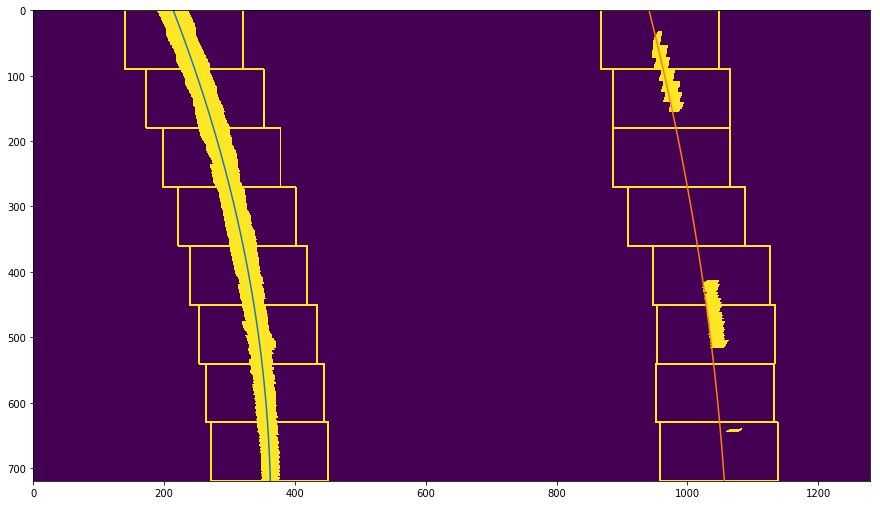

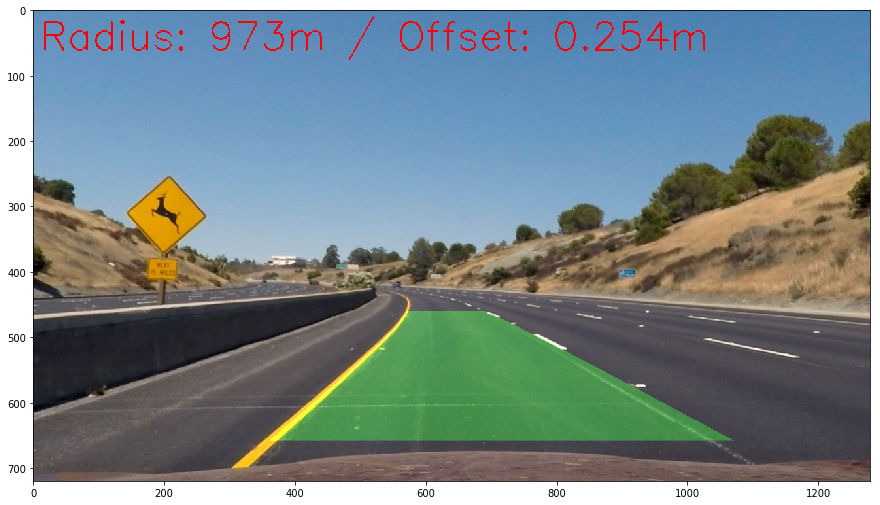

In [60]:
imgInfo = find_lines(undist_img, True)
ann_img = create_annotated_image(imgInfo, True)


In [12]:
from copy import copy

class MetaDataSaver(object):
    
    def __init__(self):
        self.current_index = 0
        self.imgInfos = [None] * 5
        
        self.lastOkInfo = None
        self.nextInfo = None
        self.keptFrames = 0
        
    def get_averaged_info(self):
        ni = self.nextInfo
        li1 = self.imgInfos[(self.current_index - 1) % 5]
        li2 = self.imgInfos[(self.current_index - 2) % 5]
        li3 = self.imgInfos[(self.current_index - 3) % 5]
        li4 = self.imgInfos[(self.current_index - 4) % 5]
        if li1 == None or li2 == None or li3 == None or li4 == None:
            return ni
        
        new_leftys = [(y1 + y2 + y3 + y4 + y5) / 5 for y1, y2, y3, y4, y5 in list(zip(ni.left_ys, li1.left_ys, li2.left_ys, li3.left_ys, li4.left_ys))]
        new_rightys = [(y1 + y2 + y3 + y4 + y5) / 5 for y1, y2, y3, y4, y5 in list(zip(ni.right_ys, li1.right_ys, li2.right_ys, li3.right_ys, li4.right_ys))]

        
        new_info = copy(ni)
        new_info.left_ys = new_leftys
        new_info.right_ys = new_rightys
        return new_info    
        
    def new_meta_data(self, imgInfo):
        
        ratio = imgInfo.left_curverad / imgInfo.right_curverad
        ratio_compared = ((imgInfo.left_curverad + imgInfo.right_curverad)) / ((self.lastOkInfo.left_curverad + self.lastOkInfo.right_curverad)) if self.lastOkInfo != None else 1
        
        ratio = ratio if ratio > 1 else 1 / ratio
        ratio_compared = ratio_compared if ratio_compared > 1 else 1 / ratio_compared
        
        
        if (ratio > 3 or ratio_compared > 2) and self.lastOkInfo != None:
            self.lastOkInfo.img_original = imgInfo.img_original
            self.keptFrames += 1
        else:
            self.lastOkInfo = imgInfo
            
        #self.imgInfos = [self.imgInfos[i] if i != self.current_index else self.lastOkInfo for i in range(5) ]
        self.imgInfos[self.current_index] = self.lastOkInfo
        self.nextInfo = self.lastOkInfo
        #return self.nextInfo
        self.current_index = (self.current_index + 1) % 5
        return self.get_averaged_info()
    


### Pipeline

In [13]:
def pipeline1(image):
       
    combined = combined_filter(image)
    
    undist = undist_image(combined)
    
    src, dst = generate_src_dst_points()
    warped, M, Minv = persective_transform(undist, src, dst)
         
    #draw_warp(undist, warped, src, dst)
    
    leftx, lefty, rightx, righty = find_line_points(warped, left.last_fit, right.last_fit)
    
    #print ('leftx, y', leftx, lefty)
    #print ('rightx, y', rightx, righty)
    lx, ly = left.add_points_to_fit(leftx, lefty)
    #print ('L x', lx)
    #print ('L y', ly)
    if not lx or not ly:
        print ('L x', lx)
        print ('L y', ly)
        return image
    left.line_fit(lx,ly)
    rx, ry = right.add_points_to_fit(rightx, righty)
    #print ('R x', rx)
    #print ('R y', ry)
    if not rx or not ry:
        print ('R x', rx)
        print ('R y', ry)
        return image
    right.line_fit(rx,ry)
    
    #print ('left', left)
    try:
        left.update() # croaks here
        right.update()
    except:
        return image
    lane_center = check_lane_width(left.current_fit, right.current_fit, image.shape)

    image_center = image.shape[1]/2
#     print(image_center)
    if lane_center - image_center> 0:
        str_pos = 'Vehicle is {0:.3f}m Left of Center'.format(abs(lane_center - image_center)*left.xm_per_pix)
    else:
        str_pos = 'Vehicle is {0:.3f}m Right of Center'.format(abs(lane_center - image_center)*left.xm_per_pix)
    
    left_curverad = left.calc_radius_of_curvature(image.shape)
    right_curverad = right.calc_radius_of_curvature(image.shape)
    str_curverad = 'Radius of Curvature : {0:.3f}m'.format((left_curverad+right_curverad)/2)
    
    info=[str_pos, str_curverad]

    result = draw_area(image, warped, M, left.current_fit, right.current_fit, info)
    
    return result

def pipeline2(image):
    #pipeline = lambda img: (transform(combined_filter((img))))
    
    combined = combined_filter(image)
    #undist = undist_image(combined)
    transformed_img = transform(undist)
    return transformed_img

meta_data_saver = MetaDataSaver()

def pipeline(image):
    undist = undist_image(image)
    meta_data = find_lines(undist)
    return create_annotated_image(meta_data_saver.new_meta_data(meta_data))

images:  ['test_images/test1.jpg']


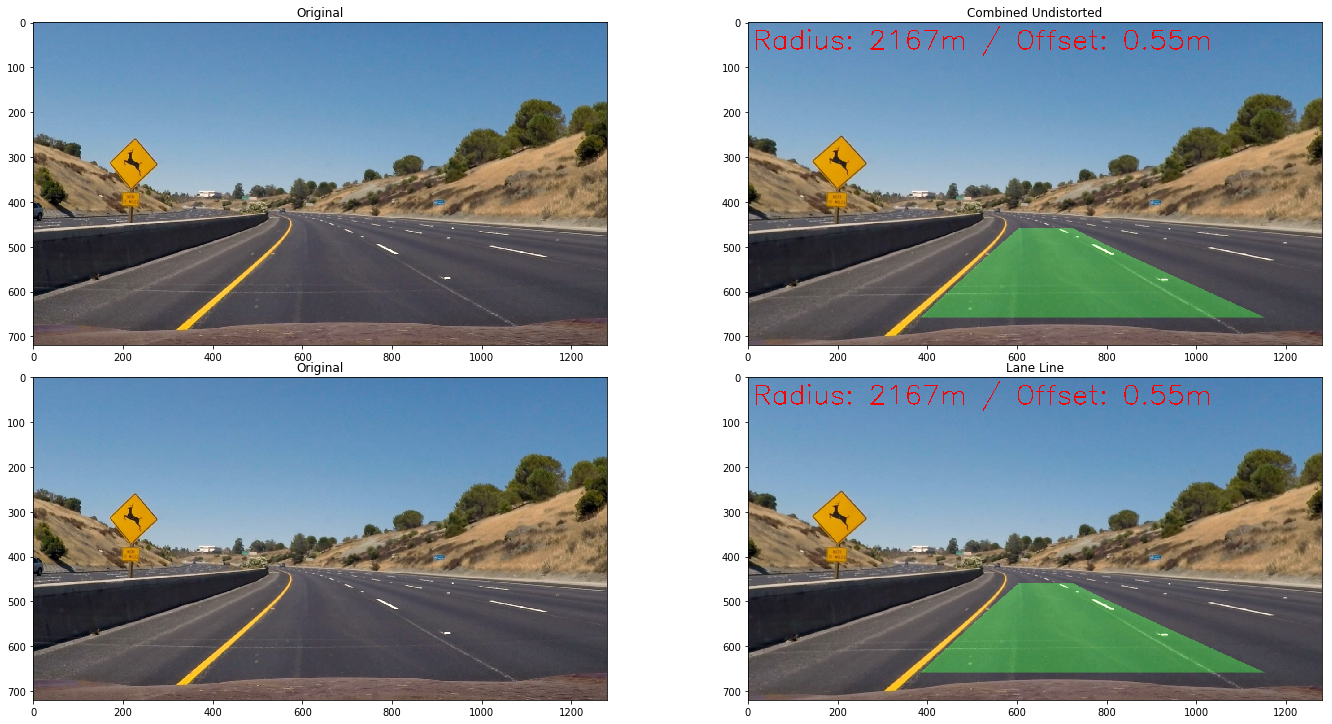

100%|█████████▉| 1260/1261 [03:52<00:00,  5.17it/s]


[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [03:42<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 5min 31s, sys: 1min, total: 6min 32s
Wall time: 3min 43s


In [20]:
%matplotlib inline

#left = Line('left')
#right = Line('right')

# Make a list of calibration images

#image = mpimg.imread('test_images/test2.jpg')

#img = pipeline1(image)
#plt.imshow(img)

# Read in and make a list of calibration images
images = glob.glob('test_images/test1.jpg')
print ('images: ', images)

# Step through the list and search for chessboard corners
#for idx, fname in enumerate(images):
#    print ('File Name:', fname)
#    img1 = cv2.imread(fname)
    
#    pipeline_img = pipeline(img1)
    
#    cv2.imshow('img', pipeline_img)
#    cv2.waitKey(500)

#cv2.destroyAllWindows()


if True:
    fname = 'test_images/straight_lines2.jpg'
    #test_image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    test_image = mpimg.imread('test_images/test2.jpg')
    pipeline_img = pipeline(test_image)
    
    fname1 = 'test_images/straight_lines5.jpg'
    #test_image1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)    
    test_image1 = mpimg.imread('test_images/test2.jpg')
    pipeline1_img = pipeline(test_image1)
    
    f, ax = plt.subplots(2, 2, figsize=(20, 10))
    f.tight_layout()
    ax[0][0].imshow(test_image)
    ax[0][0].set_title('Original')

    ax[0][1].imshow(pipeline_img)
    ax[0][1].set_title('Combined Undistorted')
    
    ax[1][0].imshow(test_image)
    ax[1][0].set_title('Original')

    ax[1][1].imshow(pipeline1_img)
    ax[1][1].set_title('Lane Line')
    
    plt.show()



#fname = 'test_images/test5.jpg'
#img1 = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)


#f, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,10))
#ax1.imshow(img1)
#ax1.set_title('Original Image', fontsize=30)

#pipeline_img = pipeline1(img1)

#ax2.imshow(pipeline_img)
#ax2.set_title('Lane Line', fontsize=30)


if True:
    output_file = 'output_project_video.mp4'
    clip = VideoFileClip("project_video.mp4")

    output_clip = clip.fl_image(pipeline)
    output_clip.ipython_display()
    %time output_clip.write_videofile(output_file, audio=False)


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [22]:


output_challenge = 'output_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
output_clip = clip.fl_image(pipeline)
# output_clip.ipython_display()
%time output_clip.write_videofile(output_challenge, audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 485/485 [01:28<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 2min 10s, sys: 24.1 s, total: 2min 34s
Wall time: 1min 29s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge))

In [24]:

output_harder_challenge = 'output_harder_challenge_video.mp4'
clip = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip.fl_image(pipeline)
# output_clip.ipython_display()
%time output_clip.write_videofile(output_harder_challenge, audio=False)

[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:44<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video.mp4 

CPU times: user 5min 28s, sys: 1min 1s, total: 6min 29s
Wall time: 3min 45s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_harder_challenge))